# General TDA pipeline

**Author:** Erik Am&eacute;zquita

**Date:** November 2025

This is a short notebook on how to compare 2 or more persistence diagrams using:
- Bottleneck distances
- Wasserstein distances
- Persistence images
- MDS (Multidimensional scaling)
- PCA (Principal component analysis)

This is by no means an exhaustive list of things to do, but it (hopefully) will provide a good starting point from which finer analyses can be devised.

**Important**: In this example, we'll look at diagrams drawn from Vietoris-Rips filtrations, but keep in mind that you can use the same outlined pipeline with any other collection of diagrams drawn from any other filtrations.

# Part I: Imports

We start importing some standard libraries and sublibraries for non-TDA stuff. For the TDA-specific computations, we'll use `ripser` and `persim` (part of `scikit-tda`).

*Optional*: 

For this Notebook, you can also use `gudhi`. When it comes to computing the Wasserstein distance with `gudhi` relies [on `POT`](https://pythonot.github.io/), which in turn relies `scipy.optimize`. You might need to either install compatible versions (using a virtual environment) or make a small edit to the `POT` files. [Check here for examples of `scipy` vs `POT` fixes](https://github.com/thaler-lab/Wasserstein/issues/36).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition, manifold, metrics, preprocessing
from scipy import spatial


from ripser import ripser
import persim

# Optional: comment them if the Wasserstein distances report errors
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance

Some general variables so we don't worry about them later. Changing them won't have much of an impact later.
- `fs`: fontsize for plots
- `colors`: list of colors for matplotlib
- `markers`: list of markers for matplotlib
- `legend_kw`: parameters for the matplotlib legends
- `mds_kw`: parameters to compute MDS
- `rng`: random number generator with a fixed seed for reproducibility purposes

In [2]:
fs = 14
colors = ['coral','dodgerblue']
markers =  ['s', 'D']
rng = np.random.default_rng(42)
legend_kw = dict(facecolor='gainsboro', framealpha=1, borderpad=0)
mds_kw = dict(n_components=2, max_iter=3000,  eps=1e-9, n_init=1, random_state=42, dissimilarity="precomputed", n_jobs=1)

# Part II: Setup

- We'll define 2 different groups of 2D pointclouds, with `N=5` pointclouds per group. (10 pointclouds total).
- Each pointcloud will have `M=100` points
- For the first group, the points will be drawn from a uniform distribution.
- The second group will have its points drawn from a normal distribution
- For each point cloud, we'll compute its persistence diagram (Vietoris-Rips in this case)

**Important**: To avoid weird errors down the line, from the diagrams we have removed the features with infinite lifetime.

In [3]:
# Generate synthetic data, compute its persistence diagram minus infinite features

M,N = 100,5
dgms = [None for _ in range(2*N)]

data = rng.uniform(size=(N*M,2))
for i in range(0,len(data),M):
    diags = ripser(data[i:i+M])
    dgms[i//M] = [ diags['dgms'][hdim][ np.all(diags['dgms'][hdim] < np.inf, axis = 1) ] for hdim in range(len(diags['dgms'])) ]

data = rng.normal(size=(N*M,2))
for i in range(0,len(data),M):
    diags = ripser(data[i:i+M])
    dgms[N + i//M] = [ diags['dgms'][hdim][ np.all(diags['dgms'][hdim] < np.inf, axis = 1) ] for hdim in range(len(diags['dgms'])) ]

# Get the max value across all diagrams: only used for visualization purposes
maxval = max([max(map(np.max, dgm)) for dgm in dgms ])

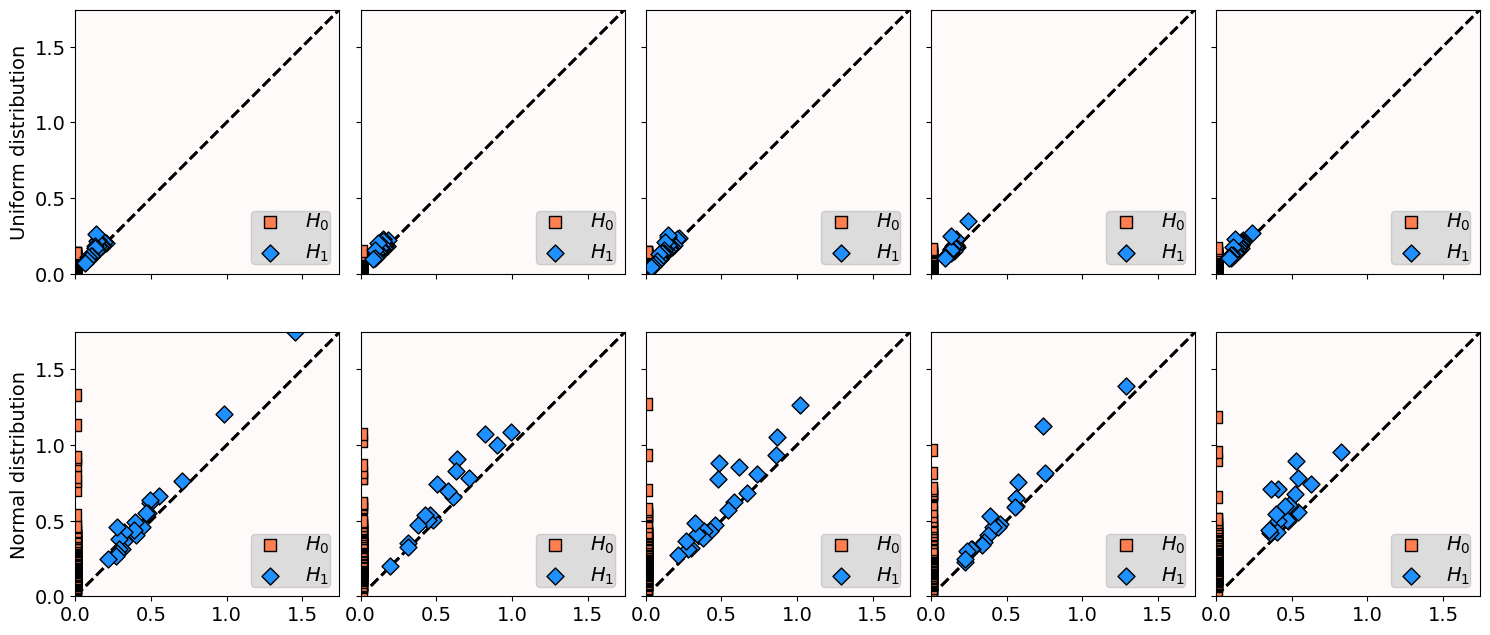

In [4]:
# Plot all 10 diagrams

fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 7), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    for j in range(len(dgms[i])):
        ax[i].axline((0,0), slope=1, ls='dashed', lw=2, zorder=1, c='k')
        ax[i].scatter(*dgms[i][j].T, s=75, fc=colors[j], ec='k', marker=markers[j], label='$H_{{{}}}$'.format(j), zorder=2)
        ax[i].legend(loc='lower right', fontsize=fs, **legend_kw)

    # Make the plots prettier
    ax[i].set_facecolor('snow')
    ax[i].scatter([0,maxval],[0,maxval],alpha=0)
    ax[i].margins(0)
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelsize=fs)

ax[0].set_ylabel('Uniform distribution', fontsize=fs)
ax[N].set_ylabel('Normal distribution', fontsize=fs)
fig.tight_layout()

# Part III: Computing distances between diagrams

The first we can do is to compute a distance between diagrams to know how similar (different) they are from each other. Ideally, diagrams originating from similar shapes/patterns will have a short distance between them. And diagrams originating from different shapes will have longer distances.

## Consider one dimension only 

We'll focus on $H_1$ since it is the one that looks the most interesting. The exact same pipeline works when looking at $H_0$. (Another reason to pick $H_1$ is that it has fewer persistent points, so the computations will be faster). 

**Important**: Unless you have a real, geometric reason to suspect connected components are almost the same as loops, never mix the points of one dimension with the points of another dimension when comparing diagrams.

In [5]:
hdim = 1

**Note:** We can compute the distance between two diagrams by first focusing only on $H_0$ and then focusing on $H_1$. This way, for two diagrams we will have two different distances. There are ways to combine these two value into a single number, but you *must* have a valid reason on why you think considering $H_0$ and $H_1$ as one would be insightful. Just because you can do it does not mean you should do it.

## The bottleneck distance

Historically, the first distance proposed to compare two persistence diagrams $D_1, D_2$ was the *bottleneck* distance. Consider a match (bijection) $\varphi$ between all the points of $D_1$ and $D_2$ (remember that the diagrams include all the points on the diagonal). Two possible matches between blue triangles and red circles are illustrated below (Fig. 8 in [Am&eacute;zquita et al 2020](https://doi.org/10.1002/dvdy.175)). 

<img src="https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/refs/heads/main/tda/figs/bottleneck_diagram.svg" alt="bottleneck diagram example" style="display: block; margin-left: auto; margin-right: auto; width:75%">

For each match, we consider its cost as the largest difference across all matched points. In the example above, the match on the left has a higher cost that the match on the right. The bottleneck distance corresponds to the lowest possible cost considering all possible matches. More formally:

$$d_B(D_1, D_2) := \inf_{\varphi:D_1\to D_2}\;\sup_{x\in D_1}\|x - \varphi(x)\|_\infty.$$

Remember that $\|\cdot\|_\infty$ is the [$L_\infty$-norm](https://en.wikipedia.org/wiki/L-infinity). Intuitively, the bottleneck distance measures what is the minimum cost to match the topology of one shape to the topology of another shape.

### Most important result: stability

The bottleneck distance is *stable* in the sense that if the original shapes wiggle a little bit (say because of noise), then the bottleneck distance between the resulting diagrams will only change a little bit. This is extremely important in the context of data science since we always have to assume that whatever real-life data we are handling, it will come with some noise. Stability guarantees that if our measured data is a bit noisy, our persistence results will be off by just a bit.

From the seminal result of [Cohen-Steiner et al 2007](https://doi.org/10.1007/s00454-006-1276-5), we know that:

$$d_B(D_1, D_2) \leq \|f_1 - f_2\|_\infty,$$

where $f_i$ is the filtration that produces diagram $D_i$. 

## Pairwise distance matrix

For our toy example, we will compute the bottleneck distances between all possible pairs. Note that this matrix has zeros in its diagonal and it is symmetric. *Ideally* we would like:

- the distance between the first five diagrams (points produced with uniform distribution) to be small
- the distance between the last five diagrams (produced with normal distribution) to also be small
- the distance between uniform and normal diagrams to be large.

### Computational note

Empirically speaking, I've noticed that `gudhi` is *considerably* faster than `persim` when it comes to computing persistence diagram distances. This difference is noticeable when your diagrams have lots of long-lived points. Compare $H_0$ with $H_1$ in our toy data example.

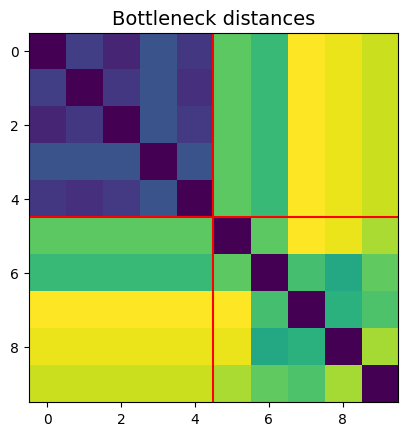

In [6]:
# Compute the pairwise matrix manually
bns = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        bn = persim.bottleneck(dgms[i][hdim], dgms[j][hdim], matching=False)
        # Alternative way to compute bottleneck distance with gudhi
        #bn = gd.bottleneck_distance(dgms[i][hdim], dgms[j][hdim])
        bns[i,j] = bn
        bns[j,i] = bn
plt.imshow(bns);

# Make it clear where the uniform/normal split happens
plt.axvline(N-.5, c='r')
plt.axhline(N-.5, c='r')
plt.title('Bottleneck distances', fontsize=fs);

Welp, that was not the full ideal. The first five diagrams are indeed close to each other. And normal diagrams are distant from uniform ones. But the normal diagrams are all over the place and it is impossible to tell if they are related or not.

## MDS: Multidimensional Scaling

To have a better sense of these distances, we can represent them in a plane [via MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling). This is an algorithm that tries to represent in 2D the present distances in the most faithful way possible. That is, if two diagrams are close to each other (in bottleneck distance terms), they will also be close to each other in 2D in their MDS representation. And viceversa: diagrams that are far apart should be represented as two points far apart in the 2D representation.

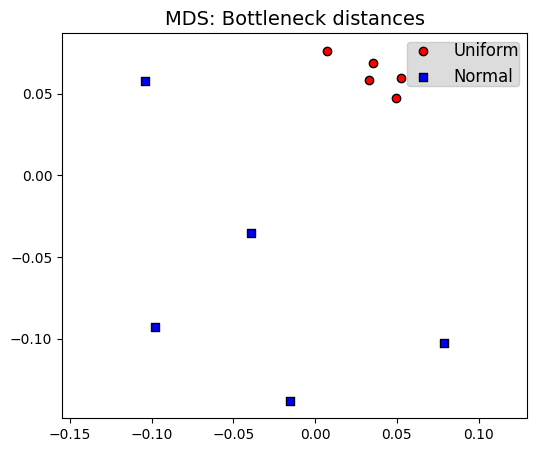

In [7]:
X_mds = manifold.MDS(**mds_kw).fit(bns).embedding_

fig, ax = plt.subplots(1,1,figsize=(6,5))
ax.scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax.scatter(*X_mds[5:].T, fc='b', ec='k', marker='s', label='Normal')
ax.legend(fontsize=0.85*fs, **legend_kw)
ax.set_aspect('equal', 'datalim')
ax.set_title('MDS: Bottleneck distances', fontsize=fs);

Sure enough, the uniform diagrams are all close to each other as expected from the pairwise distance matrix. And the normal diagrams are distinct from the uniform ones. But it is hard to say if the normal diagrams are related to each other.

**Note:** The idea of performing bottleneck distances and grouping data with MDS is nothing new. E.g. [Chazal et al 2009](https://doi.org/10.1111/j.1467-8659.2009.01516.x) and [May et al 2024](https://arxiv.org/abs/2306.06727v2).

## The Wasserstein distance

An alternative (a generalization to be more precise) of the bottleneck distance is the Wasserstein distance. Instead of considering the match cost as the largest difference, we will consider the *sum* of all differences. The $q$-th order Wasserstein distance is defined as:

$$W_q(D_1, D_2) := \inf_{\varphi:D_1\to D_2}\left(\sum_{x\in D_1}\|x-\varphi(x)\|^q_\infty\right)^{1/q}.$$

Notice that when $q=\infty$, the Wasserstein distance becomes the bottleneck distance. Remember that $1\leq q\leq\infty$ to guarantee that $\\|\cdot\|_q$ is a distance. The Wasserstein distance is also stable ([Mileyko et al 2011](https://doi.org/10.1088/0266-5611/27/12/124007)):

$$W_q(D_1, D_2) \leq C^{1/q}\|f_1 - f_2\|_\infty^{1-k/q},$$

(ignore the actual values of $C$ and $k$) whenever the filtration functions $f_1, f_2$ are nice enough (for some definition of nice).

For persistence image purposes, we'll use $q=1$. This is the $q$ value used internally by `persim` when computing Wasserstein. `gudhi` let's you compute Wassertein for any `order = q` and `internal_p` for any [$L_p$ norm](https://en.wikipedia.org/wiki/Lp_space#Lp_spaces_and_Lebesgue_integrals) (instead of [just $L_\infty$](https://en.wikipedia.org/wiki/L-infinity) as in the original definition.)

**Note:** Computing the Wasserstein distance is computationally more expensive than bottleneck since you have to keep track of all matches (instead of the costliest one). If you have lots of data, consider sacrificing some accuracy for performance with approximate Wasserstein distances [using `persim.sliced_wasserstein` instead](https://persim.scikit-tda.org/en/latest/reference/stubs/persim.sliced_wasserstein.html).

## Rinse and repeat

We can again compute a pairwise distance matrix and visualize these results in 2D via MDS. Unfortunately there is not that much of a difference in this case between bottleneck and Wasserstein.

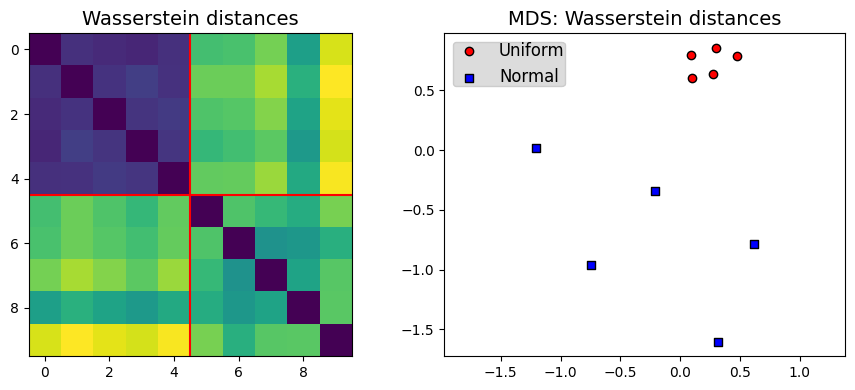

In [8]:
wds = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        wd = persim.wasserstein(dgms[i][hdim], dgms[j][hdim], matching=False)

        # With gudhi you compute various values of q (order) and do instead
        #wd = wasserstein_distance(dgms[i][hdim], dgms[j][hdim], order=1)
        wds[i,j] = wd
        wds[j,i] = wd

X_mds = manifold.MDS(**mds_kw).fit(wds).embedding_

fig, ax = plt.subplots(1,2, figsize=(9,4))

ax[0].imshow(wds);
ax[0].axvline(N-.5, c='r')
ax[0].axhline(N-.5, c='r')
ax[0].set_title('Wasserstein distances', fontsize=fs);

ax[1].scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax[1].scatter(*X_mds[5:].T, fc='b', ec='k', marker='s', label='Normal')
ax[1].legend(fontsize=0.85*fs, **legend_kw);
ax[1].set_aspect('equal', 'datalim')
ax[1].set_title('MDS: Wasserstein distances', fontsize=fs);

fig.align_titles()
fig.tight_layout()

# Part IV: Kernel representations of persistence diagrams &rarr; Persistence images

So far we have worked directly with the diagrams. Persistence diagrams are very *weird* mathematical objects. It is mathematically impossible to do much statistics beyond what we've already tried. For starters, there is no such thing as an *average* persistence diagram (no, averaging the points does not work) ([Munch et al 2015](https://doi.org/10.1214/15-EJS1030)).

Instead, we can first transform the diagrams into a much nicer mathematical object, and then we can do all the statistics we want with it. This is called a *kernel representation*. There are various kernels available that will produce different nice mathematical objects. We'll focus on *persistence images*, which represent persistent diagrams as everyday vectors.

First we need to re-think our persistence diagram as a *lifetime* diagram (`lifetime = death - birth`, essentially rotating it 45 degrees clockwise). Then we compute a weighted KDE (*kernel density estimate*, think of a heatmap) based on lifetime. This produces a *persistence surface*. To make sure that we stay on the good side of theorems, we will stick to using symmetric Gaussian kernels.

<img src="https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/refs/heads/main/mcarto/figs/GLYMA_05G092200_TDA_c02352_12.png" alt="persistence surfaces" style="display: block; margin-left: auto; margin-right: auto; width:75%">

This surface can then be discretized by a relatively small number of pixels. This produces a *persistence image* than can be thought as a long vector (as opposed to a matrix.)

<img src="https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/refs/heads/main/mcarto/figs/GLYMA_05G092200_TDA_c02352_13.png" alt="persistence images" style="display: block; margin-left: auto; margin-right: auto; width:75%">


- For `persim` purposes, we need the largest possible birth time and lifetime to guarantee that all images will have the same dimensions and resolution (making them comparable).

## Theoretical justification

Persistence images are stable under the 1-Wasserstein distance. That is: for nice enough patterns/shapes/point clouds, if they are perturbed a little bit (say, because of noise), we already know that the resulting persistence diagrams will vary just a little bit (the 1-Wasserstein distance between them will be small), and in turn, the persistence images will also vary just a little bit. 

More formally, the main result to keep in mind is Theorem 9 from [Adams et al. 2017](https://jmlr.org/papers/v18/16-337.html): If persistence diagrams $D_i$ produce persistence images $I_i$, then we have that

$$\|I_1 - I_2\|_1 \leq \textrm{(Some constants)}W_1(D_1, D_2).$$

The above result is also valid for $\|I_1-I_2\|_2$ and $\|I_1-I_2\|_\infty$.


1.4483269453048706	0.39502033591270447


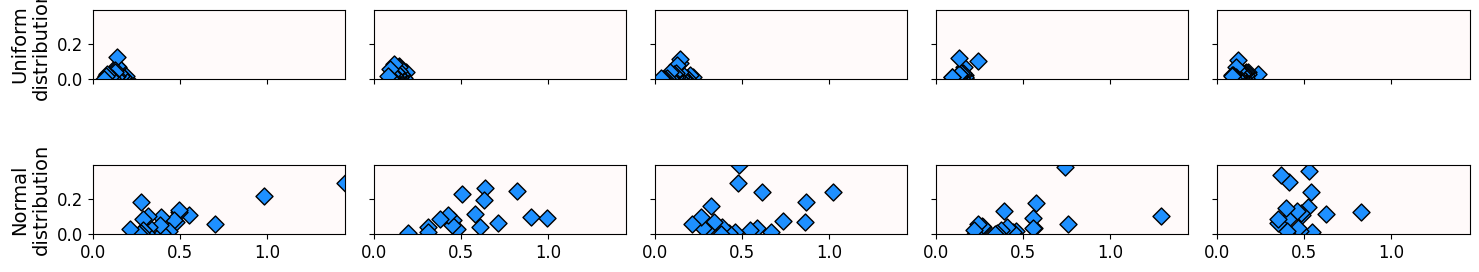

In [9]:
lt_h1 = [ np.column_stack((dgm[hdim][:,0], dgm[hdim][:,1]-dgm[hdim][:,0])) for dgm in dgms ]

max_birth, max_lt = np.max(np.vstack(lt_h1), axis=0)
print(max_birth, max_lt, sep='\t')

fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].scatter(*lt_h1[i].T, s=75, fc=colors[hdim], ec='k', marker=markers[hdim], label='$H_{{{}}}$'.format(hdim), zorder=2)

    ax[i].set_facecolor('snow')
    ax[i].set_xlim(0, max_birth)
    ax[i].set_ylim(0, max_lt)
    ax[i].set_aspect('equal')
    ax[i].tick_params(labelsize=.85*fs)

ax[0].set_ylabel('Uniform\ndistribution', fontsize=fs)
ax[N].set_ylabel('Normal\ndistribution', fontsize=fs)
fig.tight_layout()

We'll need to set various parameters. The two most important are:

- `sigma`: How spread out is the *heat* from each point in the persistent surface? Large values will capture broad features but ignore details. Small sigmas will capture details but also noise. 

- `pixsz`: How much time does every pixel represent? Large pixel values will result in very pixelated images that will capture broad features but ignore detail. Small pixel sizes will capture details but also noise: they will also produce large vectors that could be affected by the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

For both cases, *large* and *small* are relative to the largest birth and life times. I chose `pixsz = 0.15` so that the resulting images would be 5 pixels tall by 12 pixels long. So only 60 values total per diagram.

In [10]:
sigma = 0.25
pixsz = 0.15

# We make sure that the birth and lifetime ranges are integer multiples of pixel size.
pi_params = {
    'birth_range':(0, pixsz * np.ceil((max_birth + sigma)/pixsz)),
    'pers_range':(0, pixsz * np.ceil((max_lt + sigma)/pixsz)),
    'pixel_size': pixsz,
    'weight': 'persistence', # KDE weighted based on lifetime
    'weight_params': {'n': 1}, # Weight increases linearly with lifetime
    'kernel':'gaussian', # Gaussian kernel for the KDE
    'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} # symmetrical kernel}
} 

# Define a transformer with fixed parameters so all the diagrams will be treated exactly the same
# (so they'll be comparable)
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ])
print(extent)

# Transform the lifetime diagrams into persistence images
pimgs = np.asarray(pimgr.transform(lt_h1, skew=False))
pi_vmax = np.max(pimgs)
print(pimgs.shape)

[0.   1.8  0.   0.75]
(10, 12, 5)


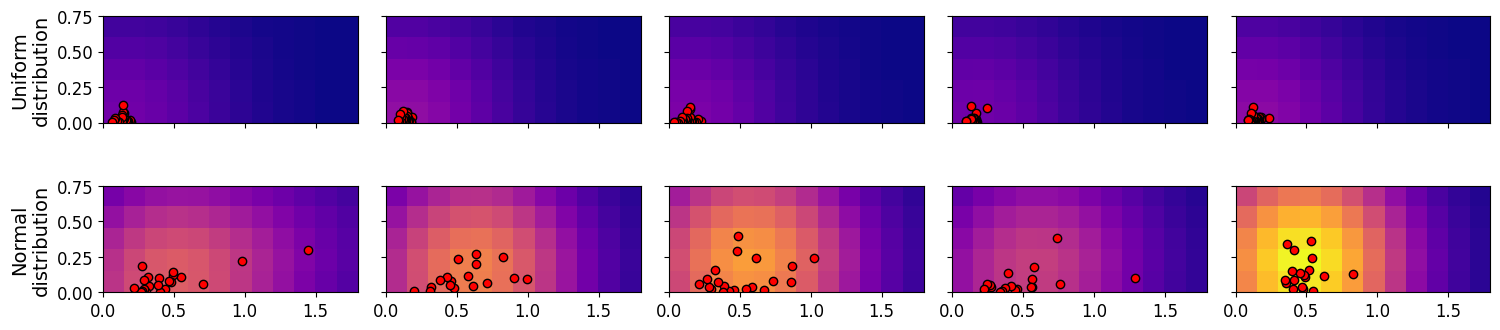

In [11]:
# Plot the images and overlay the lifetime diagram. Compare it with the lifetime diagrams plotted above

fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(len(ax)):
    ax[i].imshow(pimgs[i].T, origin='lower', cmap='plasma', vmin=0, vmax=pi_vmax, extent=extent)
    ax[i].scatter(*lt_h1[i].T, marker='o', fc='r', ec='k', zorder=2)
    #ax[i].legend(loc='upper right', fontsize=0.85*fs, facecolor='gainsboro', framealpha=1, borderpad=0)

    ax[i].tick_params(labelsize=.85*fs)

ax[0].set_ylabel('Uniform\ndistribution', fontsize=fs)
ax[N].set_ylabel('Normal\ndistribution', fontsize=fs)
fig.tight_layout()

### Rinse and repeat

We can compute the Euclidean distance between these vectors and obtain a new distance matrix and MDS representation. In this case, we get results closer to our expected ideal.

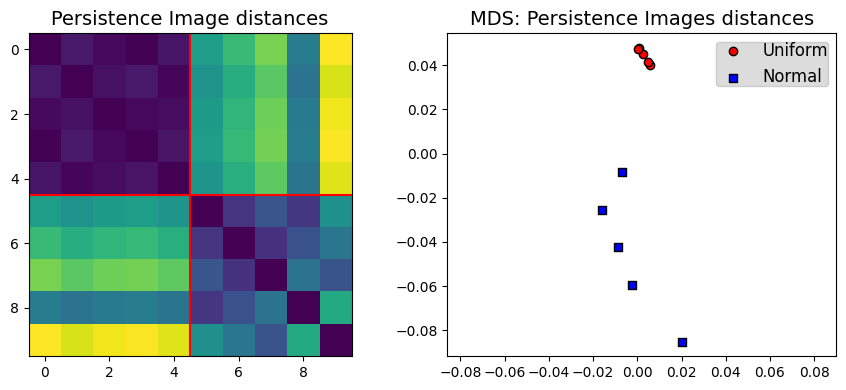

In [12]:
pids = np.zeros((len(dgms), len(dgms)))
for i in range(len(dgms)-1):
    for j in range(i+1, len(dgms)):
        pid = np.sqrt(np.sum((pimgs[j] - pimgs[i])**2))
        
        pids[i,j] = pid
        pids[j,i] = pid
X_mds = manifold.MDS(**mds_kw).fit(pids).embedding_


fig, ax = plt.subplots(1,2, figsize=(9,4))

ax[0].imshow(pids);
ax[0].axvline(N-.5, c='r')
ax[0].axhline(N-.5, c='r')
ax[0].set_title('Persistence Image distances', fontsize=fs);

ax[1].scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax[1].scatter(*X_mds[5:].T, fc='b', ec='k', marker='s', label='Normal')
ax[1].legend(fontsize=0.85*fs, **legend_kw);
ax[1].set_aspect('equal', 'datalim')
ax[1].set_title('MDS: Persistence Images distances', fontsize=fs);

fig.align_titles()
fig.tight_layout()

## Concatenating dimensions

Another big advantage of kernel representations like persistence images is that it is much more obvious how to take into account information from all dimensions at once. We still need to make separate computations for $H_0$- and $H_1$-derived images, but then we can simply concatenate the vectors.

In [13]:
lt_h0 = [ np.column_stack((dgm[0][:,0], dgm[0][:,1]-dgm[0][:,0])) for dgm in dgms ]
lt_h1 = [ np.column_stack((dgm[1][:,0], dgm[1][:,1]-dgm[1][:,0])) for dgm in dgms ]

max_birth, max_lt = np.max(np.vstack(lt_h0 + lt_h1), axis=0)
print(max_birth, max_lt, sep='\t')

# We make sure that the birth and lifetime ranges are integer multiples of pixel size.
pi_params = {'birth_range':(0, pixsz * np.ceil((max_birth + sigma)/pixsz)),
             'pers_range':(0, pixsz * np.ceil((max_lt + sigma)/pixsz)),
             'pixel_size': pixsz,
             'weight': 'persistence',
             'weight_params': {'n': 1},
             'kernel':'gaussian',
             'kernel_params':{'sigma': [[sigma, 0.0], [0.0, sigma]]} }

# Define a transformer with fixed parameters so all the diagrams (FOR ALL DIMENSIONS) will be treated exactly the same
# (so they'll be comparable)
pimgr = persim.PersistenceImager(**pi_params)
extent = np.array([ pimgr.birth_range[0], pimgr.birth_range[1], pimgr.pers_range[0], pimgr.pers_range[1] ])
xtent = (extent/pixsz).astype(int)
exxtent = extent.copy(); exxtent[1] *= 2
print(extent)

# Transform the lifetime diagrams into persistence images
pimgs0 = np.asarray(pimgr.transform(lt_h0, skew=False))
pimgs1 = np.asarray(pimgr.transform(lt_h1, skew=False))

pi_vmax0 = np.max(pimgs0)
pi_vmax1 = np.max(pimgs1)
pi_vmax = max([pi_vmax0, pi_vmax1])

print(pimgs0.shape, pimgs1.shape, sep='\t')

# Concatenate both dimensions into a single vector
# Now things look very much like the ideal!
pi0 = np.zeros((pimgs0.shape[0], pimgs0.shape[1]*pimgs0.shape[2]))
pi1 = pi0.copy()

for i in range(len(pi0)):
    pi0[i] = pimgs0[i].ravel()
    pi1[i] = pimgs1[i].ravel()

pis = np.hstack((pi0, pi1))
print(pis.shape)

1.4483269453048706	1.3319292068481445
[0.   1.8  0.   1.65]
(10, 12, 11)	(10, 12, 11)
(10, 264)


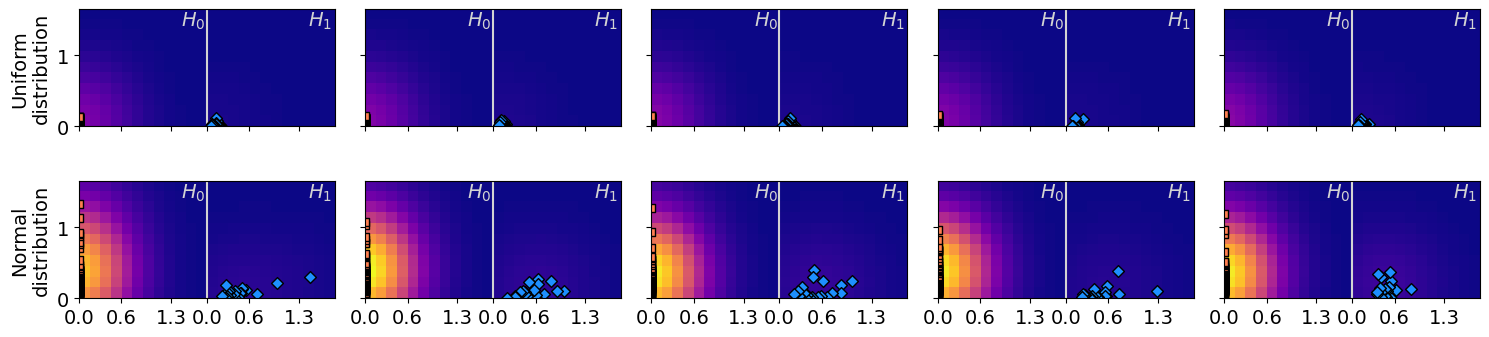

In [14]:
xlabs = np.tile(np.round(np.linspace(0, .7*extent[1], 3), 1), 2)
xticks = np.hstack((xlabs[:3], xlabs[:3]+extent[1]))

fig, ax = plt.subplots(2, len(dgms)//2, figsize=(15, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
for i in range(len(ax)):
    ll = pis[i].reshape( 2*xtent[1], xtent[3], order='C').T
    ax[i].imshow(ll, cmap='plasma', vmax=pi_vmax, vmin=0, origin='lower', extent=exxtent)
    ax[i].axvline(extent[1], c='lightgray')
    ax[i].scatter(*lt_h0[i].T, marker=markers[0], fc=colors[0], ec='k', zorder=2)
    ax[i].scatter(lt_h1[i][:,0] + extent[1], lt_h1[i][:,1], marker=markers[1], fc=colors[1], ec='k', zorder=2)
    ax[i].set_xticks(xticks, xlabs)
    ax[i].tick_params(labelsize=fs)
    for hdim in [0,1]:
        ax[i].text( .99*(hdim+1)*extent[1], .99*extent[-1], '$H_{}$'.format(hdim), c='lightgray', ha='right', va='top', fontsize=fs)
ax[0].set_ylabel('Uniform\ndistribution', fontsize=fs)
ax[N].set_ylabel('Normal\ndistribution', fontsize=fs)
fig.tight_layout();

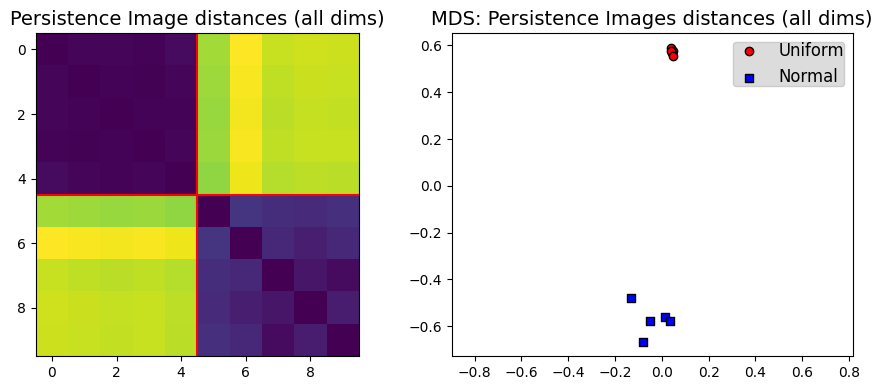

In [15]:
# Since `pis` is actually a collection of vectors, it is much more efficient to use scikit
pids = metrics.pairwise_distances(pis, metric='euclidean')

X_mds = manifold.MDS(**mds_kw).fit(pids).embedding_

fig, ax = plt.subplots(1,2, figsize=(9,4))

ax[0].imshow(pids);
ax[0].axvline(N-.5, c='r')
ax[0].axhline(N-.5, c='r')
ax[0].set_title('Persistence Image distances (all dims)', fontsize=fs);

ax[1].scatter(*X_mds[:5].T, fc='r', ec='k', marker='o', label='Uniform')
ax[1].scatter(*X_mds[5:].T, fc='b', ec='k', marker='s', label='Normal')
ax[1].legend(fontsize=0.85*fs, **legend_kw);
ax[1].set_aspect('equal', 'datalim')
ax[1].set_title('MDS: Persistence Images distances (all dims)', fontsize=fs);

fig.align_titles()
fig.tight_layout()

## Part V: Beyond MDS

Since now we have vectors, we can do much more than distances and MDS. Each vector has 60 values: let's reduce that to two via PCA ([Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)). 

**Important**: Remember to center all the values before applying PCA. Standardizing the variance, while recommended as rule of thumb, is not needed in this case because all the pixel values are comparable to each other.

In [16]:
scaler = preprocessing.StandardScaler(copy=True, with_std=False, with_mean=True).fit(pis)
data = scaler.transform(pis)
print(data.shape)

# Let's reduce our persistence images to just 6 dimensions
PCA = decomposition.PCA(n_components=6, random_state=42, svd_solver='full').fit(data)
print('Considering the first', PCA.n_components,'PCs')

pca = PCA.transform(data).astype('float32')
explained_ratio = 100*PCA.explained_variance_ratio_
print(explained_ratio)
print('Total explained var:\t', np.sum(explained_ratio), np.sum(explained_ratio[:2]))

(10, 264)
Considering the first 6 PCs
[9.93814742e+01 4.80700304e-01 1.19662664e-01 1.43154774e-02
 3.52058361e-03 2.34629207e-04]
Total explained var:	 99.99990782581258 99.8621744719656


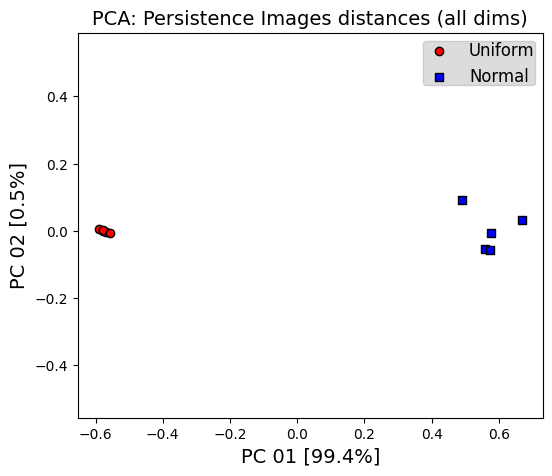

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

ax.scatter(*pca[:5, :2].T, fc='r', ec='k', marker='o', label='Uniform')
ax.scatter(*pca[5:, :2].T, fc='b', ec='k', marker='s', label='Normal')
ax.legend(fontsize=0.85*fs, **legend_kw);
ax.set_aspect('equal', 'datalim')
ax.set_title('PCA: Persistence Images distances (all dims)', fontsize=fs)
ax.set_xlabel('PC 01 [{:.1f}%]'.format(explained_ratio[0]), fontsize=fs)
ax.set_ylabel('PC 02 [{:.1f}%]'.format(explained_ratio[1]), fontsize=fs);

## Making the most out of PCA

For our toy example, PCA produces the same result as MDS. Except that PCA is much more informative and efficient. 

- PCA is much more **computationally efficient** than MDS: this is important if you are dealing with a large amount of data
- With PCA we can assign **importance** to each axis, unlike MDS. In this case, the first principal component pretty much summarizes all there is to know about our persistence images.

## PCA Loadings

One cool thing of PCA is that we can take a look at the **loadings** to determine which pixels of the persistence images are the most informative: why do the points in the PCA end up where they end up?

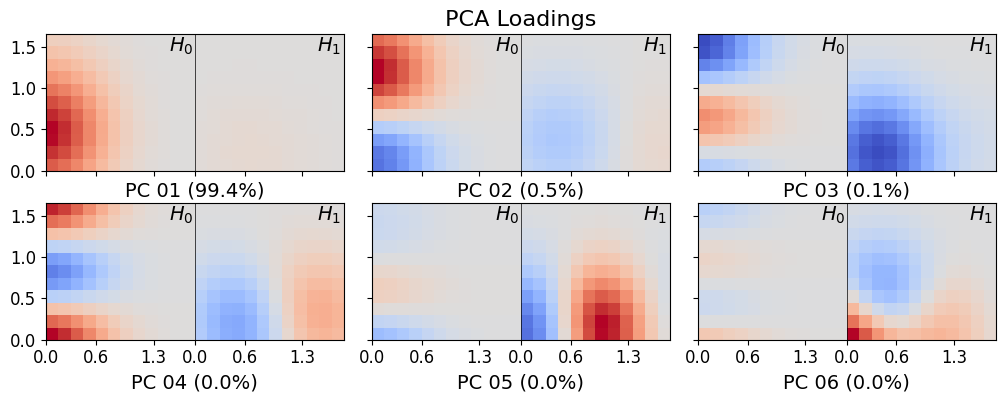

In [18]:
# Plot loadings
# Red = contributes positively to the PC value
# Blue = contributes negatively to the PC value
# Gray = does not contribute in any way

loadings = PCA.components_.T * np.sqrt(PCA.explained_variance_)

fig, ax = plt.subplots(2, 3, figsize=(10, 4), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel(); i = 0
for i in range(loadings.shape[1]):
    ll = loadings[:,i].reshape( 2*xtent[1], xtent[3], order='C').T
    vmax = np.max(np.abs(ll))
    ax[i].imshow(ll, cmap='coolwarm', vmax=vmax, vmin=-vmax, origin='lower', extent=exxtent)
    ax[i].set_xlabel('PC {:02d} ({:.1f}%)'.format(i+1, explained_ratio[i]), fontsize=fs)
    ax[i].axvline(extent[1], c='k', lw=0.5)
    ax[i].set_xticks(xticks, xlabs)
    ax[i].tick_params(labelsize=.85*fs)
    for hdim in [0,1]:
        ax[i].text( .99*(hdim+1)*extent[1], .99*extent[-1], '$H_{}$'.format(hdim), c='k', ha='right', va='top', fontsize=fs)

ax[1].set_title('PCA Loadings', fontsize=1.15*fs)
fig.tight_layout();

From the plot above we can already understand the toy data better:
1. $H_0$ differences are truly night and day between uniform and normal diagrams: $H_0$ dominates PC1, which in turn dominates the whole summary.
2. The number of connected components that have a lifetime between 0.3 and 0.7 is the main difference between uniform and normal diagrams.
3. Shorter lived connected components bring PC2 down, while longer connected components bring it up.
4. $H_1$ is only truly reflected when we consider PC3

From here, it is worth thinking about big picture goals. Do we want to classify normal vs uniform diagrams? If so, we can simply just look at $H_0$ and ignore $H_1$. This conclusion was not totally obvious when we looked at the diagrams for the first time.

Or maybe we want to look at nuances in loop formations. In that case, we should always ignore $H_0$. Otherwise, it will override whatever information $H_1$ brings in to the table.

## Supervised/unsupervised learning

Another cool thing of PCA is that, by the end of the day, it is a linear transformation _aka_ matrix multiplication. That means we can take new persistence images, center them, and apply the PCA linear transformation we already have at hand. We have already *trained* a PCA model: 
- it produces negative PC1 values if the input persistence image comes from a uniform distribution
- it produces positive PC1 values if the input comes from a normal distribution

Let's make a few more new point clouds and apply the PCA model at hand with `.transform`.

**Note**: Unlike PCA, you cannot incorporate new data to an old MDS.

In [26]:
# Generate NEW synthetic data, compute its persistence diagram minus infinite features
# First five are uniform
# Last five are normal

# New random number generator to guarantee we have NEW data values
new_rng = np.random.default_rng(1)
new_dgms = [None for _ in range(2*N)]

new_data = rng.uniform(size=(N*M,2))
for i in range(0,len(new_data),M):
    diags = ripser(new_data[i:i+M])
    new_dgms[i//M] = [ diags['dgms'][hdim][ np.all(diags['dgms'][hdim] < np.inf, axis = 1) ] for hdim in range(len(diags['dgms'])) ]

new_data = rng.normal(size=(N*M,2))
for i in range(0,len(new_data),M):
    diags = ripser(new_data[i:i+M])
    new_dgms[N + i//M] = [ diags['dgms'][hdim][ np.all(diags['dgms'][hdim] < np.inf, axis = 1) ] for hdim in range(len(diags['dgms'])) ]

In [52]:
# Compute the persistence images of these new diagrams
# We are using the EXACT SAME parameters

new_lt_h0 = [ np.column_stack((dgm[0][:,0], dgm[0][:,1]-dgm[0][:,0])) for dgm in new_dgms ]
new_lt_h1 = [ np.column_stack((dgm[1][:,0], dgm[1][:,1]-dgm[1][:,0])) for dgm in new_dgms ]

# Transform the lifetime diagrams into persistence images
new_pimgs0 = np.asarray(pimgr.transform(new_lt_h0, skew=False))
new_pimgs1 = np.asarray(pimgr.transform(new_lt_h1, skew=False))

# Concatenate both dimensions into a single vector
new_pis = np.hstack ( ( np.array(list(map(np.ravel, new_pimgs0))), np.array(list(map(np.ravel, new_pimgs1))) ) )
print(new_pis.shape)

(10, 264)


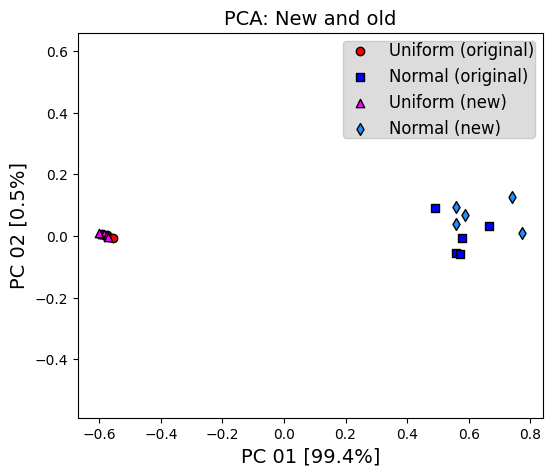

In [57]:
# Center the data BASED ON previous data
new_data = scaler.transform(new_pis)

# Transform it BASED ON previous PCA
new_pca = PCA.transform(new_data).astype('float32')

# Plot the resulting values
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.scatter(*pca[:5, :2].T, fc='r', ec='k', marker='o', label='Uniform (original)')
ax.scatter(*pca[5:, :2].T, fc='b', ec='k', marker='s', label='Normal (original)')

ax.scatter(*new_pca[:5, :2].T, fc='magenta', ec='k', marker='^', label='Uniform (new)')
ax.scatter(*new_pca[5:, :2].T, fc='dodgerblue', ec='k', marker='d', label='Normal (new)')

ax.legend(fontsize=0.85*fs, **legend_kw);
ax.set_aspect('equal', 'datalim')
ax.set_title('PCA: New and old', fontsize=fs)
ax.set_xlabel('PC 01 [{:.1f}%]'.format(explained_ratio[0]), fontsize=fs)
ax.set_ylabel('PC 02 [{:.1f}%]'.format(explained_ratio[1]), fontsize=fs);

### Success!

Our old PCA transformed new data exactly the way we wanted it! This could be the basis of a classifier.

## Inverse transform

So far our pipeline has been:

> Point Cloud &rarr; Persistence Diagram &rarr; Persistence Image &rarr; PCA Plot

What if we start the other way around? Given a set of PC values, how do the original shapes look like? While we cannot reverse all the arrows, PCA allows us to do

> Persistence Image &larr; PCA Plot.

From there, we can do some educated guesses on how the original diagrams look like. And from there we can do an even more nebulous guesswork on how the original point cloud looks like. But hey, it's better than nothing.

**Note:** The inverse PCA function is not bijective. It is impossible to go perfectly from a few dimensions to a lot of dimensions. Some information will be lost in this back and forth. However, in nice case, most of the lost information will be noise/irrelevant.

### Exploring a continuum

Back to our toy data. The PC1 axis defines a continuum: negative values come from uniform distributions, while positive values come from normal distributions. What happens in between? Let's place a point in the origin of the PCA plot and work backwards.

In [129]:
# Let's check a few points at -0.5, -0.25, 0, +0.25, +0.5

continuum = np.linspace(-0.5, 0.5, 5)
origin = np.zeros((len(continuum), PCA.get_params()['n_components']))
for i in range(len(origin)):
    origin[i, :3] = [continuum[i], continuum[i]/10, continuum[i]/10]

# Inverse PCA
inv_pis = PCA.inverse_transform(origin)

# Remember to scale back
inv_pis = scaler.inverse_transform(inv_pis)

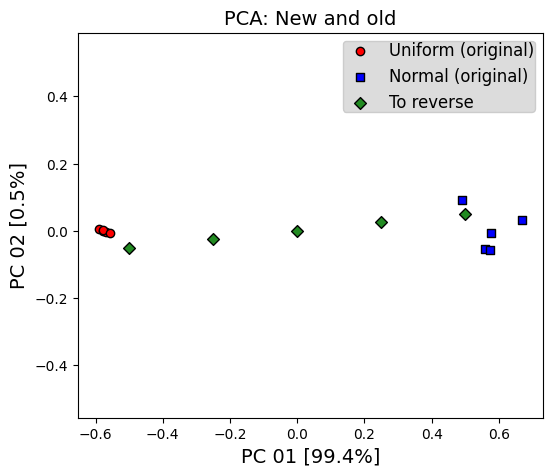

In [130]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.scatter(*pca[:5, :2].T, fc='r', ec='k', marker='o', label='Uniform (original)')
ax.scatter(*pca[5:, :2].T, fc='b', ec='k', marker='s', label='Normal (original)')
ax.scatter(origin[:,0], origin[:,1], fc='forestgreen', ec='k', marker='D', label='To reverse')

ax.legend(fontsize=0.85*fs, **legend_kw);
ax.set_aspect('equal', 'datalim')
ax.set_title('PCA: New and old', fontsize=fs)
ax.set_xlabel('PC 01 [{:.1f}%]'.format(explained_ratio[0]), fontsize=fs)
ax.set_ylabel('PC 02 [{:.1f}%]'.format(explained_ratio[1]), fontsize=fs);

The above works for any data. For persistence image purposes, remember that all the values must be non-negative. A **crude** way to go about it is to make all negative values zero. Another equally crude way is to add the most negative value to everything. Another way is to rescale everything so that the minimum is zero but the maximum remains unchanged. 

Either way is crude and hard to fully justify mathematically. In general, only go this way if your negative values are small.

In [131]:
# Check there are no negative values
nneg = np.sum(inv_pis < 0)
print('Number of negative values:\t', nneg, ' [{:.2f}% of total]'.format(100*nneg/inv_pis.size))
if nneg > 0 :
    negs = np.abs(inv_pis[inv_pis < 0])
    print(np.min(pis), np.max(negs))
    print(np.max(pis), np.max(inv_pis))

    # Rescaling so that minimum is 0
    # but maximum is unchanged
    inv_pis = inv_pis.max() * (inv_pis - inv_pis.min())/(inv_pis.max() - inv_pis.min())

else:
    print('No need to do crude procedures!')

Number of negative values:	 0  [0.00% of total]


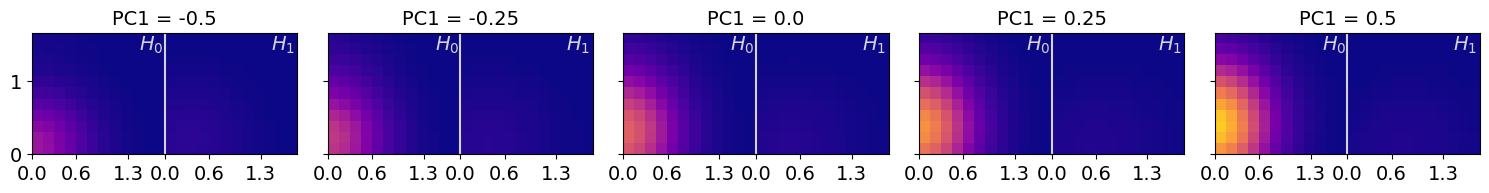

In [132]:
fig, ax = plt.subplots(1, len(continuum), figsize=(15, 3), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel();

for i in range(len(ax)):
    ll = inv_pis[i].reshape( 2*xtent[1], xtent[3], order='C').T
    ax[i].imshow(ll, cmap='plasma', vmax=pi_vmax, vmin=0, origin='lower', extent=exxtent)
    ax[i].axvline(extent[1], c='lightgray')
    ax[i].set_xticks(xticks, xlabs)
    ax[i].tick_params(labelsize=fs)
    ax[i].set_title('PC1 = {}'.format(continuum[i]), fontsize=fs)
    for hdim in [0,1]:
        ax[i].text( .99*(hdim+1)*extent[1], .99*extent[-1], '$H_{}$'.format(hdim), c='lightgray', ha='right', va='top', fontsize=fs)
fig.tight_layout();

As PC1 value increases, we have more and more weight in the (0.3,0.7) y-axis interval of $H_0$. This could mean that we have more connected components merging around the 0.5 radius. Notice that we could have arrived to this same conclusion by looking at the loadings.

---

# Now you are ready to explore your own data!

Keep in mind that once you have vectors (thanks to persistence images) you can plenty more stuff than PCA depending on what's your ultimate goal. For example:
- dimension reduction and manifold learning algorithms
- clustering
- supervised/unsupervised classification schemes
- linear/nonlinear regression

Persistence images are not the only kernels available. There are other ways to transform diagrams into vectors. There has been reported success when using 
- Persistence Landscapes
- Carlsson coordinates
- template functions, to name a few. 